In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from joblib import parallel_backend
from sklearn.model_selection import train_test_split
import re
import math

%matplotlib inline

# Get the data

In [2]:
# Load the medical insurance dataset from a CSV file into a pandas DataFrame
# source: https://www.kaggle.com/datasets/shivadumnawar/health-insurance-dataset
# The downloaded CSV file is located in a directory named "dataset" in the current working directory

df = pd.read_csv("dataset/insurance.csv")

In [3]:
# Display the first few rows of the DataFrame
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Display the last few rows of the DataFrame
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [5]:
# Get a concise summary of the DataFrame, including column data types, non-null counts, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Generate descriptive statistics for the numerical columns in the DataFrame
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# Get the dimensions of the DataFrame (number of rows, number of columns)
df.shape

(1338, 7)

In [8]:
# Count the number of missing values in each column of the DataFrame
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Remove outliers
Removing outliers from a dataset is essential for enhancing model performance, reducing variance, and ensuring the validity of statistical assumptions. Outliers can distort statistical measures, introduce noise, and violate assumptions, leading to biased results and inaccurate interpretations. By removing outliers, the data become more representative of the underlying patterns, improving the robustness and interpretability of the model. However, it's crucial to exercise caution and consider domain knowledge when deciding to remove outliers, as they may contain valuable information or represent genuine data points.

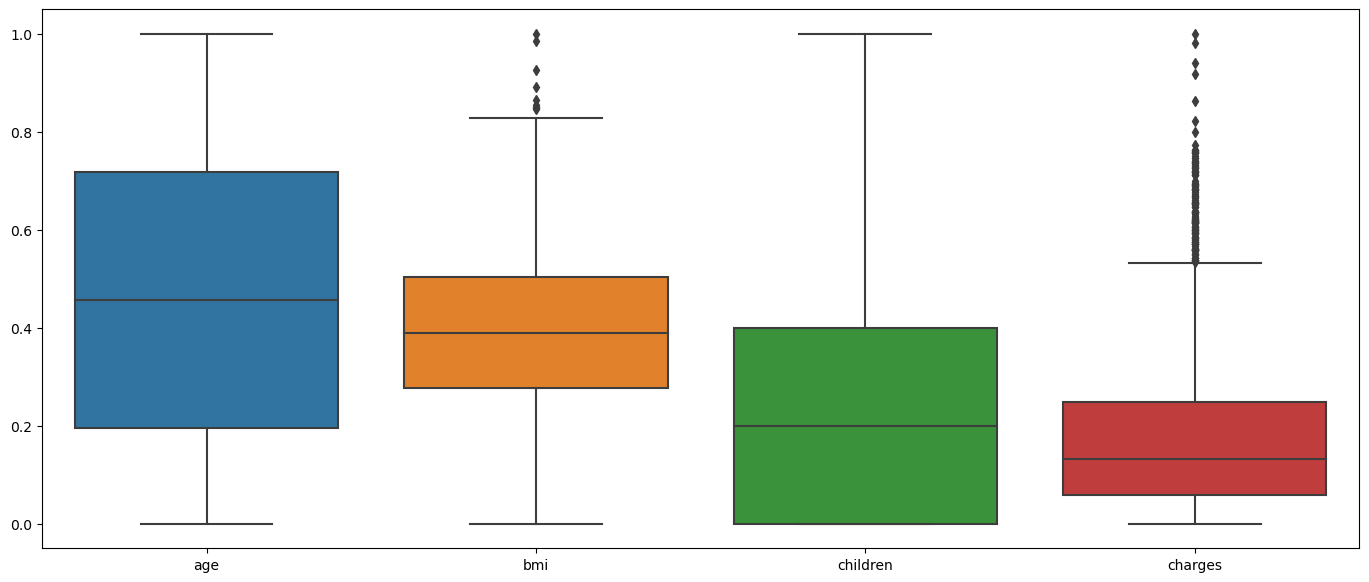

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Separate categorical columns from numerical columns
df_cat = df.select_dtypes(include = [object])
df_num = df.drop(columns = df_cat.columns, axis = 1)

# Scale the numerical columns using Min-Max scaling to bring them to a similar scale for visualization
df_num_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_num), columns = df_num.columns)

plt.figure(figsize = (17, 7))
sns.boxplot(data = df_num_scaled)
plt.show()

In [10]:
# Calculate the skewness for each numerical column in the DataFrame
for col in df_num.columns:
    print('The skewness for {} is: {}'.format(col, df[col].skew()))

The skewness for age is: 0.05567251565299186
The skewness for bmi is: 0.2840471105987448
The skewness for children is: 0.9383804401702414
The skewness for charges is: 1.5158796580240388


In [11]:
# Calculate the kurtosis for each numerical column in the DataFrame
for col in df_num.columns:
    print('The kurtosis for {} is: {}'.format(col, df[col].skew()))

The kurtosis for age is: 0.05567251565299186
The kurtosis for bmi is: 0.2840471105987448
The kurtosis for children is: 0.9383804401702414
The kurtosis for charges is: 1.5158796580240388


In [12]:
# Calculate the 99.5th percentile for each numerical column in the DataFrame
for col in df_num.columns:
    print('The the 99.5% percentile for {} is: {}'.format(col, df[col].quantile(0.995)))


The the 99.5% percentile for age is: 64.0
The the 99.5% percentile for bmi is: 47.54520000000001
The the 99.5% percentile for children is: 5.0
The the 99.5% percentile for charges is: 50086.98487310009


In [13]:
# Filter out extreme values or outliers from each numerical column in the DataFrame
for col in df_num.columns:
    # Keep rows where the value in each column is less than the 99.5th percentile
    df = df[df[col] < df[col].quantile(0.995)].reset_index(drop=True)

In [14]:
df.shape

(1284, 7)

In [15]:
def draw_histograms(df, rows, cols):
    fig = plt.figure(figsize = (10, 10))
    for idx, feature in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, idx + 1)
        df.hist(bins = 20, ax = ax, facecolor = 'midnightblue')
        ax.set_title('Distribution of '+feature)
        ax.set_yscale('log')  # Set y-axis scale to logarithmic for better visualization if needed
    fig.tight_layout()
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2040\3541620019.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins = 20, ax = ax, facecolor = 'midnightblue')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2040\3541620019.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins = 20, ax = ax, facecolor = 'midnightblue')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2040\3541620019.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins = 20, ax = ax, facecolor = 'midnightblue')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2040\3541620019.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins = 20, ax = ax, facecolor = 'midnightblue')


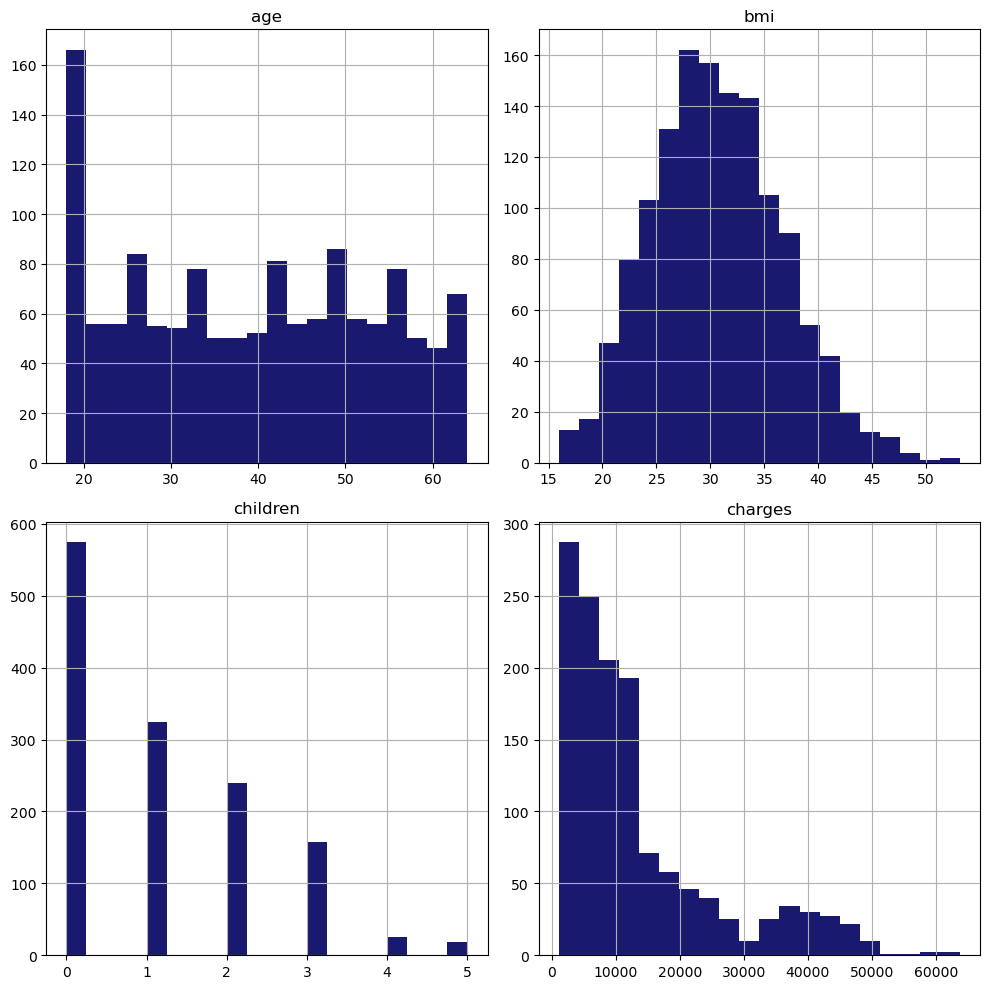

In [16]:
draw_histograms(df_num, 2, 2)

# Gain Insights to the data

In [17]:
# Group the data by the "sex" column and calculate the mean age for each group
df.groupby(["sex"])["age"].mean().reset_index()

,sex,age
0,female,39.106583
1,male,38.546440


In [18]:
# Group the data by the combination of "region" and "sex" columns
# Calculate the mean BMI for each group
df.groupby(["region", "sex"])["bmi"].mean().reset_index()

,region,sex,bmi
0,northeast,female,29.069395
1,northeast,male,28.975601
2,northwest,female,29.257013
3,northwest,male,29.058576
4,southeast,female,32.542321
5,southeast,male,33.619143
6,southwest,female,29.880519
7,southwest,male,31.150968


In [19]:
# Group the data by the combination of "region" and "sex" columns
# Calculate the mean charges for each group
df.groupby(["region", "sex"])["charges"].mean().reset_index()

,region,sex,charges
0,northeast,female,12652.809593
1,northeast,male,13977.597883
2,northwest,female,12088.793628
3,northwest,male,11927.941129
4,southeast,female,13163.471054
5,southeast,male,15353.473156
6,southwest,female,10589.015628
7,southwest,male,13072.546590


In [20]:
# Group the data by the combination of "region" and "sex" columns
# Calculate the mean age for each group
df.groupby(["region", "sex"])["age"].mean().reset_index()

,region,sex,age
0,northeast,female,39.343949
1,northeast,male,38.740506
2,northwest,female,39.176101
3,northwest,male,38.392405
4,southeast,female,38.500000
5,southeast,male,38.120000
6,southwest,female,39.454545
7,southwest,male,38.987097


In [21]:
# Group the data by the combination of "region" and "sex" columns
# Count the occurrences of "smoker" for each group
df.groupby(["region", "sex"])["smoker"].size().reset_index()

,region,sex,smoker
0,northeast,female,157
1,northeast,male,158
2,northwest,female,159
3,northwest,male,158
4,southeast,female,168
5,southeast,male,175
6,southwest,female,154
7,southwest,male,155


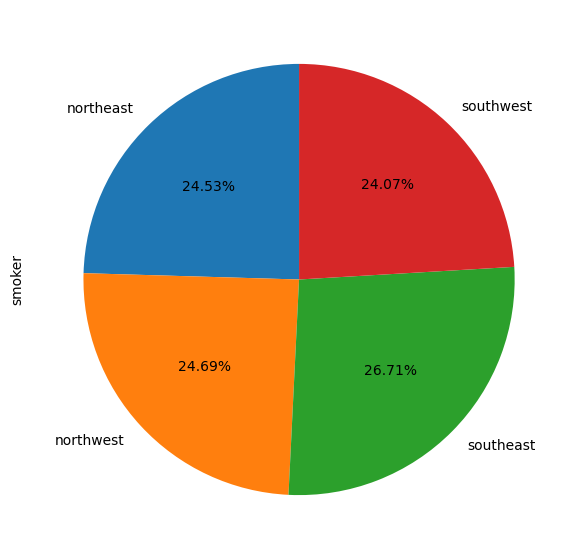

In [22]:
# Group the data by the "region" column and count the occurrences of "smoker" for each region
grouped_data = df.groupby(["region"])["smoker"].size().reset_index()

# Set the index of the resulting DataFrame to "region"
grouped_data.set_index('region', inplace=True)

# Create a pie chart to visualize the distribution of smokers across regions
grouped_data.plot(kind = "pie",
                  figsize = (7, 7),
                  startangle = 90,
                  subplots = True,
                  autopct = lambda x: '%0.2f%%' % x,
                  legend = False)
plt.show()

# Pipeline
A pipeline in Python, typically used in machine learning workflows, is a sequential series of data processing steps. Each step can include data preprocessing, feature selection, model fitting, and prediction. Pipelines ensure that data flows smoothly through each step, making it easier to organize and reproduce complex workflows. By chaining together multiple processing steps, pipelines streamline the process of building and deploying machine learning models, allowing for efficient experimentation and deployment. Additionally, pipelines facilitate parameter tuning and cross-validation, making it simpler to optimize model performance. Overall, pipelines are a powerful tool for automating and scaling machine learning workflows, improving productivity and reproducibility in data science projects.

In [23]:
cat_cols = df_cat.columns
num_cols = df_num.columns

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols = []):
        self.num_cols = num_cols

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # Feature Engineering
        
        X = pd.DataFrame(X, columns = num_cols)
        
        df['age_bmi_ratio'] = df['age'] / df['bmi']
        df['age_smoker_interaction'] = df['age'] * df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

        
        global feats
        feats = ["age_bmi_ratio", "age_smoker_interaction"]
        
        return X.values

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer



num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribute_adder', AttributeAdder(num_cols = num_cols)),
    ('standard_scaler', StandardScaler()),
])

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import itertools


# Define a column transformer to apply different preprocessing steps to numerical and categorical columns
mid_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),  # Apply the numerical pipeline to numerical columns
    ("cat", OneHotEncoder(), cat_cols),  # Apply one-hot encoding to categorical columns
])

In [27]:
mid_pipeline.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribute_adder',
                                                  AttributeAdder(num_cols=Index(['age', 'bmi', 'children', 'charges'], dtype='object'))),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 Index(['age', 'bmi', 'children', 'charges'], dtype='object')),
                                ('cat', OneHotEncoder(),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

In [28]:
# This function, TransArrToDF, is designed to transform a given DataFrame using a specified pipeline
# and return the transformed data as a new DataFrame
def TransArrToDF(pipleline, dataframe = df, feats = []):

    transformed_data = pipleline.transform(dataframe)
    
    mid_pipeline.fit(dataframe) # this one specifically has to be fitted for the cat names
    cat_encoder = mid_pipeline.named_transformers_["cat"]
    
    # Create a list of categorical feature names after one-hot encoding
    cat_ohe_list = []
    for bas in cat_encoder.categories_:
        cat_ohe_list += [x for x in bas]

    # Combine numerical column names, additional features, and one-hot encoded categorical feature names
    column_names = list(num_cols) + feats + cat_ohe_list
    
    # Create a new DataFrame with the transformed data and column names
    return pd.DataFrame(data=transformed_data, columns=column_names)

In [29]:
df = TransArrToDF(mid_pipeline)

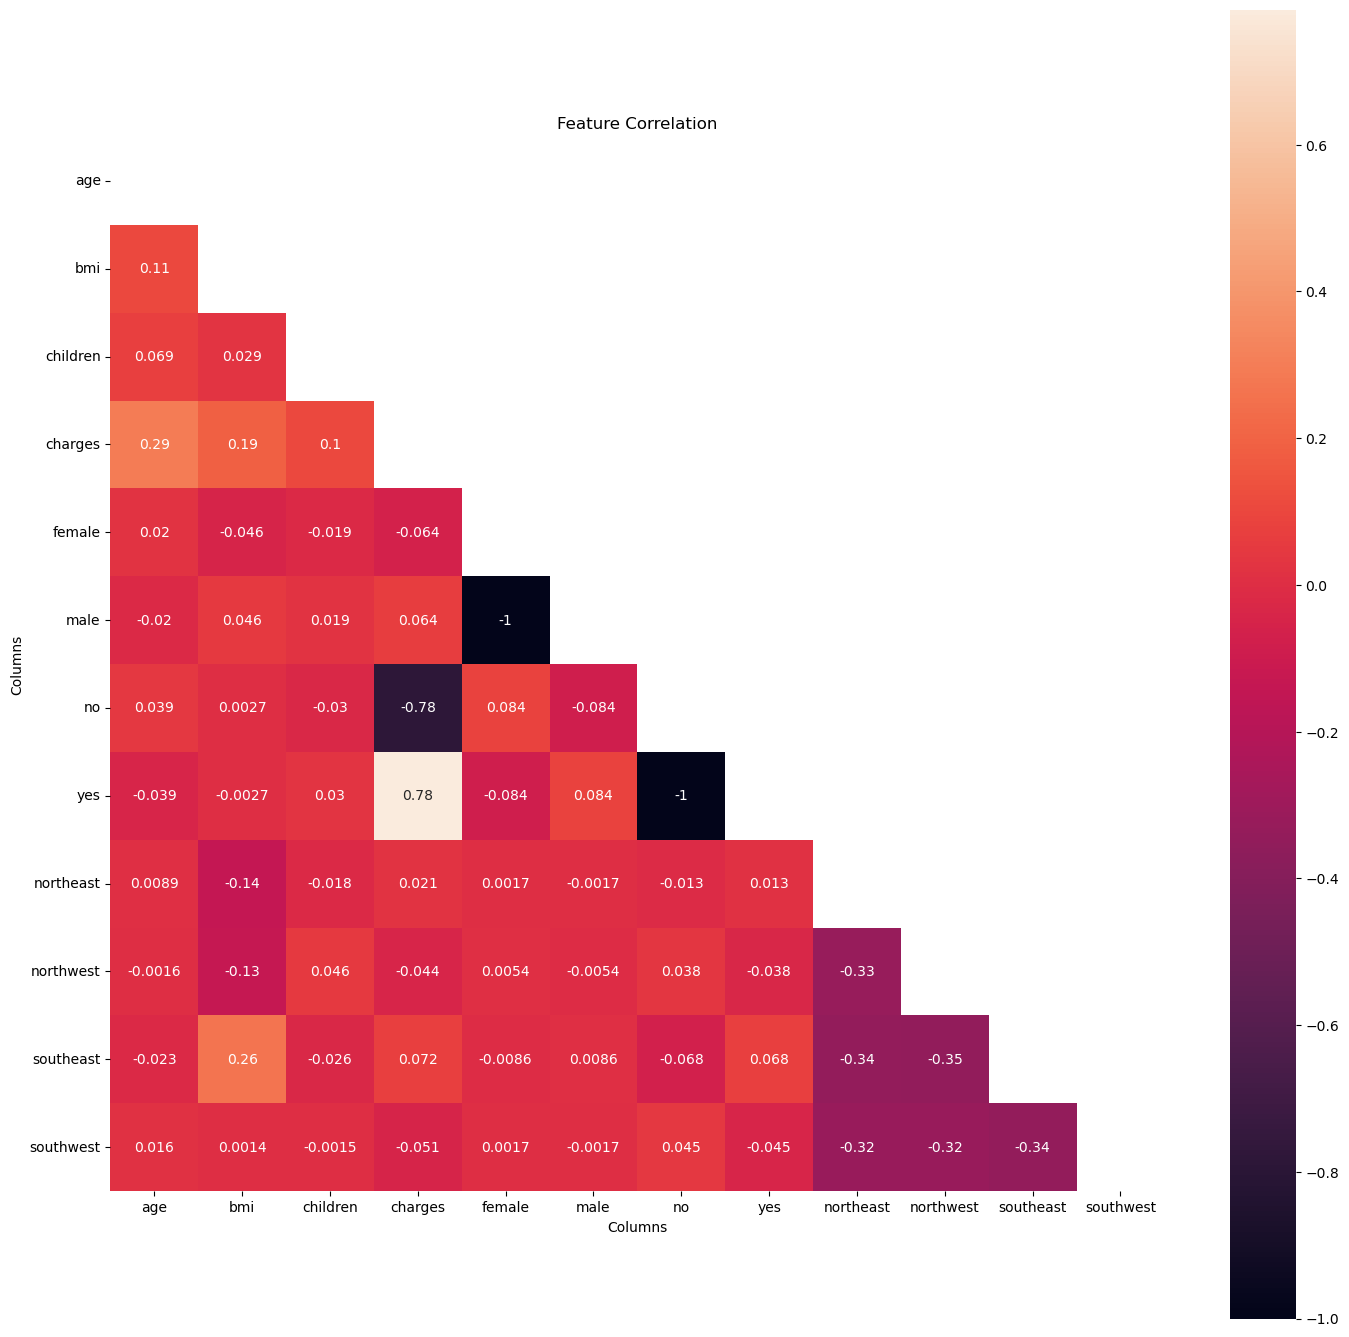

In [30]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

corr_matrix = df.select_dtypes(include = numerics).corr()
mask = np.zeros_like(corr_matrix, dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (17, 17))

sns.heatmap(corr_matrix,
           annot = True,
           square = True,
           fmt = ".2g",
           mask = mask,
           ax = ax).set(
title = "Feature Correlation", xlabel = "Columns", ylabel = "Columns")

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({"xtick.bottom": True}, {"ytick.bottom": True})

In [31]:
y = df["charges"].values
X = df.drop(["charges"], axis=1)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle=True, random_state=42, test_size=0.2)

In [33]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, PassiveAggressiveRegressor, SGDRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb


# Define a list of regressors to use
regressors = [
    Ridge(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(),
#     AdaBoostRegressor(),
    GradientBoostingRegressor(),
#     KNeighborsRegressor(),
    SVR(),
#     GaussianProcessRegressor(),
    BayesianRidge(),
#     ElasticNet(),
#     PassiveAggressiveRegressor(),
#     ExtraTreesRegressor(),
#     BaggingRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    xgb.XGBRegressor()
]


regressor_names = [re.findall(r'[\w]+', str(reg.__class__.__name__))[0] for reg in regressors]



# Define a parameter grid for each regressor
param_grids = [
    {'alpha':[1e-8,1e-3,1e-2,1,5,10,30,45,100]},  # Ridge
#     {'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # DecisionTreeRegressor
#     {'n_estimators': [50, 100, 200, 1000], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # RandomForestRegressor
#     {'n_estimators': [50, 100, 200, 1000], 'learning_rate': [0.1, 0.5, 1]},  # AdaBoostRegressor
    {'n_estimators': [50, 100, 200, 1000], 'learning_rate': [0.1, 0.5, 1], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # GradientBoostingRegressor
#     {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]},  # KNeighborsRegressor
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.5, 1]},  # SVR
#     {'alpha': [1e-2, 1e-1, 1]},  # GaussianProcessRegressor
    {'alpha_1': [1e-6, 1e-5, 1e-4], 'alpha_2': [1e-6, 1e-5, 1e-4], 'lambda_1': [1e-6, 1e-5, 1e-4], 'lambda_2': [1e-6, 1e-5, 1e-4]},  # BayesianRidge
#     {'alpha': [0.1, 1, 10], 'l1_ratio': [0.25, 0.5, 0.75]},  # ElasticNet
#     {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.5, 1]},  # PassiveAggressiveRegressor
#     {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # ExtraTreesRegressor
#     {'n_estimators': [100, 500, 3000, 7000], 'max_samples': [0.5, 0.75, 1.0]},  # BaggingRegressor
    {'iterations': [100, 500, 3000, 7000], 'learning_rate': [0.03, 0.1, 0.3]},  # CatBoostRegressor
    {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.1, 0.3]},  # LGBMRegressor
    {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.1, 0.3]}  # XGBRegressor
]


# Lists to store MSE values
train_mse = []
val_mse = []
best_params_list = []


# Perform a grid search for each regressor
for i, reg in enumerate(regressors):
    with parallel_backend('threading'):  # Use threading for parallel processing
        grid_search = GridSearchCV(reg, param_grid=param_grids[i], scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True), n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
    # Store the training and validation MSE
    train_mse.append(-grid_search.best_score_)
    y_pred = grid_search.predict(X_val)
    val_mse.append(mean_squared_error(y_val, y_pred))

    # Store the best parameters
    best_params_list.append(grid_search.best_params_)

    # Print best parameters and MSE
    print(f"Best parameters for regressor {regressor_names[i]}: {grid_search.best_params_}")
    print(f"Training MSE for regressor {regressor_names[i]}: {-grid_search.best_score_}")
    print(f"Validation MSE for regressor {regressor_names[i]}: {val_mse[-1]}")
    print("\n")

Best parameters for regressor Ridge: {'alpha': 1}
Training MSE for regressor Ridge: 0.27406575671582106
Validation MSE for regressor Ridge: 0.18847758976337572


Best parameters for regressor GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 50, 'n_estimators': 50}
Training MSE for regressor GradientBoostingRegressor: 0.1613858231319209
Validation MSE for regressor GradientBoostingRegressor: 0.07959448868795319


Best parameters for regressor SVR: {'C': 1, 'epsilon': 0.1}
Training MSE for regressor SVR: 0.17598733892002522
Validation MSE for regressor SVR: 0.10427442179574871


Best parameters for regressor BayesianRidge: {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}
Training MSE for regressor BayesianRidge: 0.2714601098426102
Validation MSE for regressor BayesianRidge: 0.188504725919243




C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\catboost\core.py", line 5807, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best parameters for regressor CatBoostRegressor: {'iterations': 500, 'learning_rate': 0.03}
Training MSE for regressor CatBoostRegressor: 0.17354229615596944
Validation MSE for regressor CatBoostRegressor: 0.09064786150369282


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1027, number of used features: 11
[LightGBM] [Info] Start training from score 0.005832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [34]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error


# Define the regressors with their best parameters
Ridge_best_params = Ridge(**best_params_list[0])
GradientBoostingRegressor_best_params = GradientBoostingRegressor(**best_params_list[1])
SVR_best_params = SVR(**best_params_list[2])
BayesianRidge_best_params = BayesianRidge(**best_params_list[3])
CatBoostRegressor_best_params = CatBoostRegressor(**best_params_list[4], verbose=False)
LGBMRegressor_best_params = LGBMRegressor(**best_params_list[5])
XGB_best_params = xgb.XGBRegressor(**best_params_list[6])


regressors=(Ridge_best_params,
            GradientBoostingRegressor_best_params,
            SVR_best_params,
            BayesianRidge_best_params,
            CatBoostRegressor_best_params,
            LGBMRegressor_best_params,
            XGB_best_params
           )

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=regressors,
                                meta_regressor=CatBoostRegressor_best_params,
                                use_features_in_secondary=True)

stack_gen

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x00000267F4AA8250>,
                    regressors=(Ridge(alpha=1),
                                GradientBoostingRegressor(min_samples_split=50,
                                                          n_estimators=50),
                                SVR(C=1),
                                BayesianRidge(alpha_1=0.0001, lambda_2=0.0001),
                                <catboost.core.CatBoostRegressor object at 0x00000267F4AA8250>,
                                LGBMRegressor(learning_rate=0.03, max_depth=4),
                                XGB...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.03, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=3,
                                             max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...)),
                    use_features_in_secondary=True)

In [35]:
# Blend models in order to make the final predictions more robust to overfitting

def algs_weights(stack_weight, selected_algs_idx, val_mse):
    val_mse = np.array(val_mse)
    selected_mse = val_mse[selected_algs_idx]
    inverse_mse = 1 - selected_mse
    other_weights = (inverse_mse/sum(inverse_mse))*(1 - stack_weight)
    return other_weights

def blended_predictions(X):
    return ((algs_weights_list[0] * Ridge_best_params.predict(X)) + \
            (algs_weights_list[1] * GradientBoostingRegressor_best_params.predict(X)) + \
            (algs_weights_list[2] * SVR_best_params.predict(X)) + \
            (algs_weights_list[3] * BayesianRidge_best_params.predict(X)) + \
            (algs_weights_list[4] * CatBoostRegressor_best_params.predict(X)) + \
            (algs_weights_list[5] * LGBMRegressor_best_params.predict(X)) + \
            (algs_weights_list[6] * XGB_best_params.predict(np.array(X))) + \
            (0.35 * stack_gen.predict(np.array(X))))

In [36]:
Ridge_best_params.fit(X_train, y_train)
GradientBoostingRegressor_best_params.fit(X_train, y_train)
SVR_best_params.fit(X_train, y_train)
BayesianRidge_best_params.fit(X_train, y_train)
CatBoostRegressor_best_params.fit(X_train, y_train)
LGBMRegressor_best_params.fit(X_train, y_train)
XGB_best_params.fit(X_train, y_train)
stack_gen.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1027, number of used features: 11
[LightGBM] [Info] Start training from score 0.005832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 11
[LightGBM] [Info] Start training from score 0.006239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 secon

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1027, number of used features: 11
[LightGBM] [Info] Start training from score 0.005832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x00000267F4AA8250>,
                    regressors=(Ridge(alpha=1),
                                GradientBoostingRegressor(min_samples_split=50,
                                                          n_estimators=50),
                                SVR(C=1),
                                BayesianRidge(alpha_1=0.0001, lambda_2=0.0001),
                                <catboost.core.CatBoostRegressor object at 0x00000267F4AA8250>,
                                LGBMRegressor(learning_rate=0.03, max_depth=4),
                                XGB...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.03, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=3,
                                             max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...)),
                    use_features_in_secondary=True)

In [37]:
# algs_weights_list = algs_weights(0.35, [0, 4, 6, 8, 13, 14, 15], val_mse)
algs_weights_list = algs_weights(0.35, [0, 1, 2, 3, 4, 5, 6], val_mse)


y_pred_scaled = blended_predictions(X_val)

mse_val = mean_squared_error(y_val, y_pred_scaled)

print("MSE is: {}".format(mse_val))

val_mse.append(mse_val)

y_pred_train = blended_predictions(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)

train_mse.append(mse_train)

MSE is: 0.08540236931067387


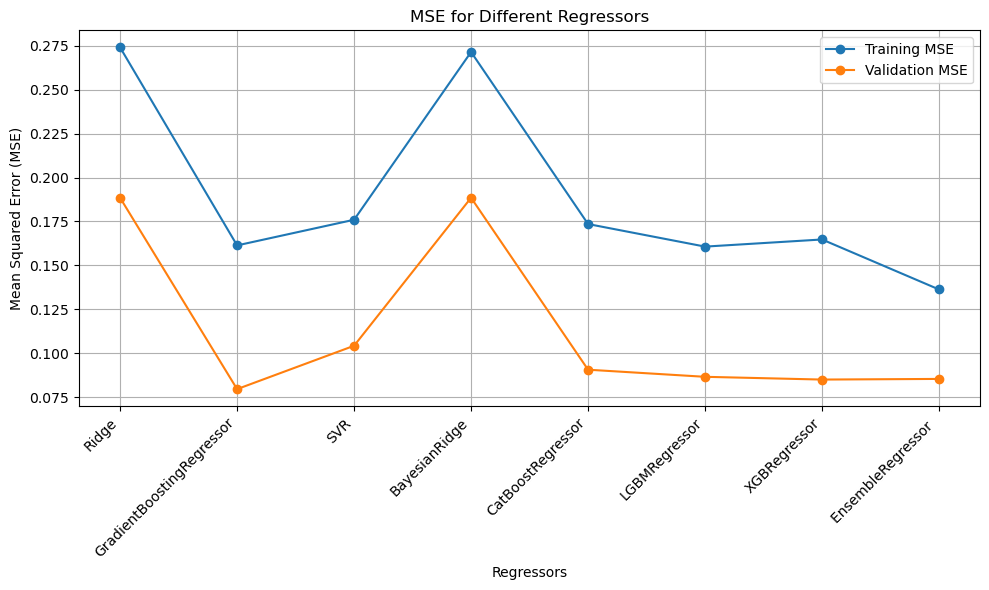

In [38]:
regressor_names = regressor_names + ['EnsembleRegressor ']

# Plotting
plt.figure(figsize=(10, 6))

# Plot training MSE
plt.plot(range(len(regressor_names)), train_mse, label='Training MSE', marker='o')

# Plot validation MSE
plt.plot(range(len(regressor_names)), val_mse, label='Validation MSE', marker='o')

# Set x-axis labels as regressor names

plt.xticks(range(len(regressor_names)), regressor_names, rotation=45, ha='right')

# Add labels and title
plt.xlabel('Regressors')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Regressors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()